In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [2]:
# get all data set we need
# these four files should be in the same folder with this ipython notebook
covid19_confirmed_US = pd.read_csv("time_series_covid19_confirmed_US.csv")
covid19_deaths_US = pd.read_csv("time_series_covid19_deaths_US.csv")
abridged = pd.read_csv("abridged_couties.csv")
states_418 = pd.read_csv("4.18states.csv")

In [3]:
# Step #1 :Data Cleaning / preprocessing:

In [4]:
# State level confirmed/death data (updated to 4.18)
state_confirmed = covid19_confirmed_US.loc[:,'Province_State':]
state_deaths = covid19_deaths_US.loc[:,'Province_State':]

state_confirmed = state_confirmed.drop(columns =['Lat','Long_','Combined_Key','Country_Region'])
state_deaths = state_deaths.drop(columns =['Lat','Long_','Combined_Key','Country_Region'])

state_confirmed = state_confirmed.groupby(['Province_State']).sum().transpose()
state_deaths= state_deaths.groupby(['Province_State']).sum().transpose().drop(['Population'])



In [5]:
# census data for each state

# First seprate age into three range:

abridged.fillna(0, inplace = True)
abridged["age<20"] = np.sum(abridged.loc[:,"PopMale<52010":"PopFmle15-192010"], axis = 1)
abridged['20<=age<65'] = np.sum(abridged.loc[:,"PopMale20-242010":"PopFmle60-642010"], axis = 1)
abridged['age>=65'] = np.sum(abridged.loc[:,"PopMale65-742010":"PopFmle>842010"], axis = 1)

# calculate num of smoker and diabetes per county
abridged['smoker'] = abridged['Smokers_Percentage'] * (abridged['20<=age<65'] + abridged['age>=65']) /100
abridged['smoker'] = abridged['smoker'].astype(int)
abridged['diabetes'] = abridged['DiabetesPercentage'] * (abridged['20<=age<65'] + abridged['age>=65']) /100
abridged['diabetes'] = abridged['diabetes'].astype(int)
abridged['STATEFP'] = abridged['STATEFP'].astype(int)

# drop the last two row, since they are empty rows.
abridged = abridged.iloc[0:3242]

In [6]:
#select features from the abridged
abridged = abridged.loc[:,['STATEFP', 'StateName', 'POP_LATITUDE', 'POP_LONGITUDE', 'PopulationEstimate2018', '#EligibleforMedicare2018',
       'MedicareEnrollment,AgedTot2017', 'DiabetesPercentage',
       'HeartDiseaseMortality', 'StrokeMortality',
       '#FTEHospitalTotal2017',
       "TotalM.D.'s,TotNon-FedandFed2017", '#HospParticipatinginNetwork2017',
       '#Hospitals', '#ICU_beds',
       'SVIPercentile', 'HPSAShortage', 'HPSAServedPop', 'HPSAUnderservedPop',
       'age<20', '20<=age<65', 'age>=65','smoker', 'diabetes']
]


In [7]:
#select features from the 4.18 data
states_418 = states_418.loc[:,['FIPS','Confirmed','People_Tested','People_Hospitalized','Testing_Rate']]
states_418.fillna(0, inplace = True)
states_418['FIPS'] = states_418['FIPS'].astype(int)
states_418 = states_418[states_418['FIPS'] != 0]

In [8]:
# this cell is used to calculate data we used in introduction section and not used in any following cells
world_418 = pd.read_csv("4.18states.csv")
total_confirmed = world_418['Confirmed'].sum()
total_death = world_418['Deaths'].sum()
total_country = set(world_418['Country_Region'])
mortality_rate = np.mean(world_418['Mortality_Rate'])
total_confirmed, total_death, total_country, mortality_rate

(859536,
 44835,
 {'Australia',
  'Canada',
  'China',
  'Denmark',
  'France',
  'Netherlands',
  'US',
  'United Kingdom'},
 2.5253367659138592)

In [9]:
# joining census data and 4.18 data in state level:
state_level_stat = abridged.groupby('StateName',as_index = False).agg({'PopulationEstimate2018':'sum', '#EligibleforMedicare2018':'sum',"MedicareEnrollment,AgedTot2017":'sum', 'smoker':'sum', 'diabetes': 'sum',
'#FTEHospitalTotal2017':'sum' ,
"TotalM.D.'s,TotNon-FedandFed2017" :'sum',
'#HospParticipatinginNetwork2017':'sum',
'#Hospitals':'sum', '#ICU_beds':'sum',
'HPSAShortage':'sum','HPSAServedPop':'sum',
'HPSAUnderservedPop':'sum', 'POP_LATITUDE': 'mean',
'POP_LONGITUDE': 'mean','SVIPercentile': 'mean',
'STATEFP': 'max', 'age<20':'sum', '20<=age<65':'sum', 'age>=65':'sum'})
state_level_stat = state_level_stat[state_level_stat['STATEFP'] != 0]
state_level_stat = state_level_stat.merge(states_418, how = 'inner', left_on = 'STATEFP', right_on = 'FIPS',validate = 'one_to_one')


In [10]:
# Step #2 : Data Visualization

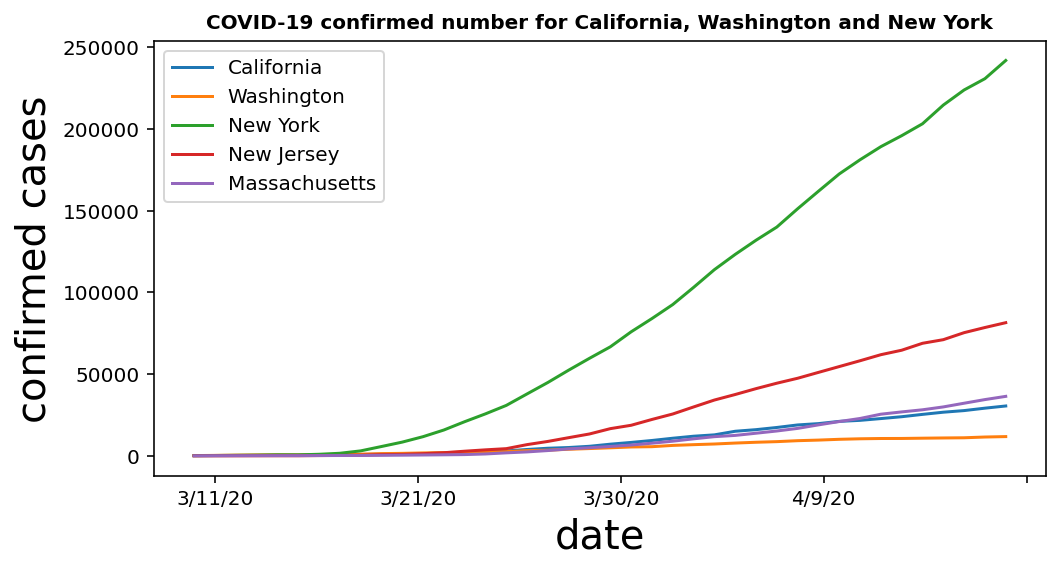

In [11]:
# Plot confirmed population for California Washington, New York, New Jersey and Massachusetts
state_confirmed = state_confirmed.tail(40)
plt.figure(figsize=(8, 4))
plt.plot(state_confirmed['California'], label="California")
plt.plot(state_confirmed['Washington'], label="Washington")
plt.plot(state_confirmed['New York'], label="New York")
plt.plot(state_confirmed['New Jersey'], label="New Jersey")
plt.plot(state_confirmed['Massachusetts'], label="Massachusetts")
plt.legend()
plt.title("COVID-19 confirmed number for California, Washington and New York", fontsize=10, fontweight='bold')
plt.xlabel("date", fontsize=20)
plt.ylabel("confirmed cases", fontsize=20)
plt.xticks(np.linspace(1, 40, 5));

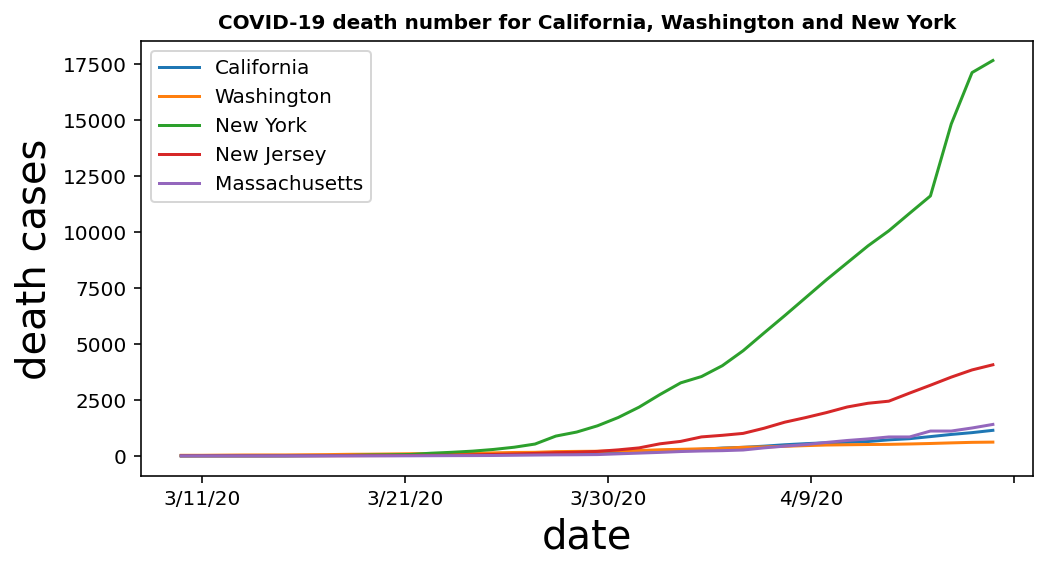

In [12]:
# Plot confirmed population for California, Washington, New York, New Jersey and Massachusetts
state_deaths = state_deaths.tail(40)
plt.figure(figsize=(8, 4))
plt.plot(state_deaths['California'], label="California")
plt.plot(state_deaths['Washington'], label="Washington")
plt.plot(state_deaths['New York'], label="New York")
plt.plot(state_deaths['New Jersey'], label="New Jersey")
plt.plot(state_deaths['Massachusetts'], label="Massachusetts")
plt.legend()
plt.title("COVID-19 death number for California, Washington and New York", fontsize = 10, fontweight='bold')
plt.xlabel("date", fontsize=20)
plt.ylabel("death cases", fontsize=20)
plt.xticks(np.linspace(1, 40, 5));

In [13]:
# Graph the World Choropleth Map for Coivd-19, 4.18
fig = go.Figure(data=go.Bar(y=[2, 3, 1]))
data_418 = pd.read_csv("4.18states.csv")
country_total_list = data_418.groupby('Country_Region')['Confirmed'].sum().to_list()
country_list = data_418["Country_Region"].tolist()
country_set = set(country_list)
country_list = list(country_set)
country_list.sort()

country_df = pd.DataFrame(list(zip(country_list, country_total_list)), 
               columns =['Country', 'Total_Cases'])

colors = ["#F3F299", "#F3CB38", "#FFBC46", "#F38335", "#F36335",  "#F02A2A", "#CF1919", "#A11818"]

fig = go.Figure(data=go.Choropleth(
    locationmode = "country names",
    locations = country_df['Country'],
    z = country_df['Total_Cases'],
    text = country_df['Total_Cases'],
    colorscale = colors,
    autocolorscale=False,
    reversescale=False,
    colorbar_title = 'Covid-19 Cases Level',
))
fig.update_layout(
    title_text='Reported World Covid-19 Cases',
    font = {"size": 15},
    margin={"r":0,"t":40,"l":0,"b":0},
#     paper_bgcolor='#93DDFF',
#     plot_bgcolor='#72CBF4',
    geo=dict(
        bgcolor= 'rgba(0,0,0,0)',lakecolor='#26769B',
        showcoastlines=True,
    ),
)

In [14]:
# Graph the US Choropleth Map for Coivd-19, 4.18
state_total_list = state_level_stat.groupby('StateName')['Confirmed'].sum().to_list()
state_list = state_level_stat['StateName'].tolist()
state_set = set(state_list)
state_list = list(state_set)
state_list.sort()

state_df = pd.DataFrame(list(zip(state_list, state_total_list)),
               columns =['State', 'Total_Cases'])

fig_state = go.Figure(data=go.Choropleth(
    locationmode = 'USA-states',
    locations = state_df['State'],
    z = state_df['Total_Cases'],
    text = state_df['Total_Cases'],
    colorscale = 'Reds',
    autocolorscale=False,
    reversescale=False,
    colorbar_title = 'Covid-19 Cases Level',
))
fig_state.update_layout(
    title_text='Reported United States Covid-19 Cases',
    font = {"size": 15},
    margin={"r":0,"t":40,"l":0,"b":0},
    geo=dict(
        scope='usa',
        bgcolor= 'rgba(0,0,0,0)',lakecolor='#26769B',
        showcoastlines=True,
    ),
)


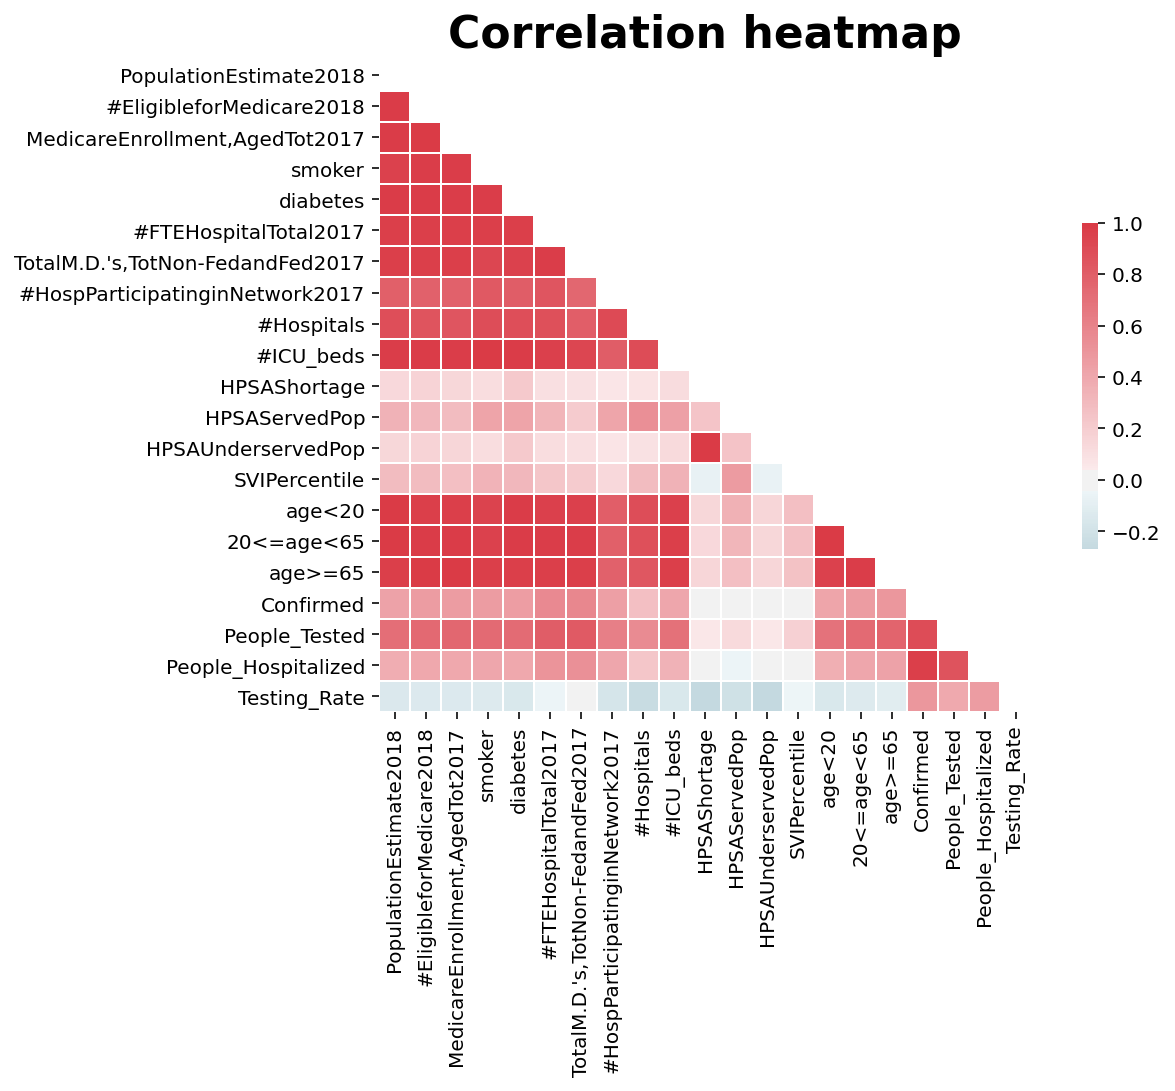

In [15]:
# Plot correlation map of all the selected features
corr = state_level_stat.drop(columns = ["POP_LATITUDE", "POP_LONGITUDE", 'STATEFP', 'FIPS', 'StateName']).corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(9, 6))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title("Correlation heatmap", fontsize = 22, fontweight='bold');


In [37]:
# the correlation of confirmed number with all features
corr["Confirmed"].sort_values(ascending=False)[1:6]

People_Hospitalized                 0.973668
People_Tested                       0.905835
TotalM.D.'s,TotNon-FedandFed2017    0.581842
#FTEHospitalTotal2017               0.562816
age>=65                             0.492052
Name: Confirmed, dtype: float64

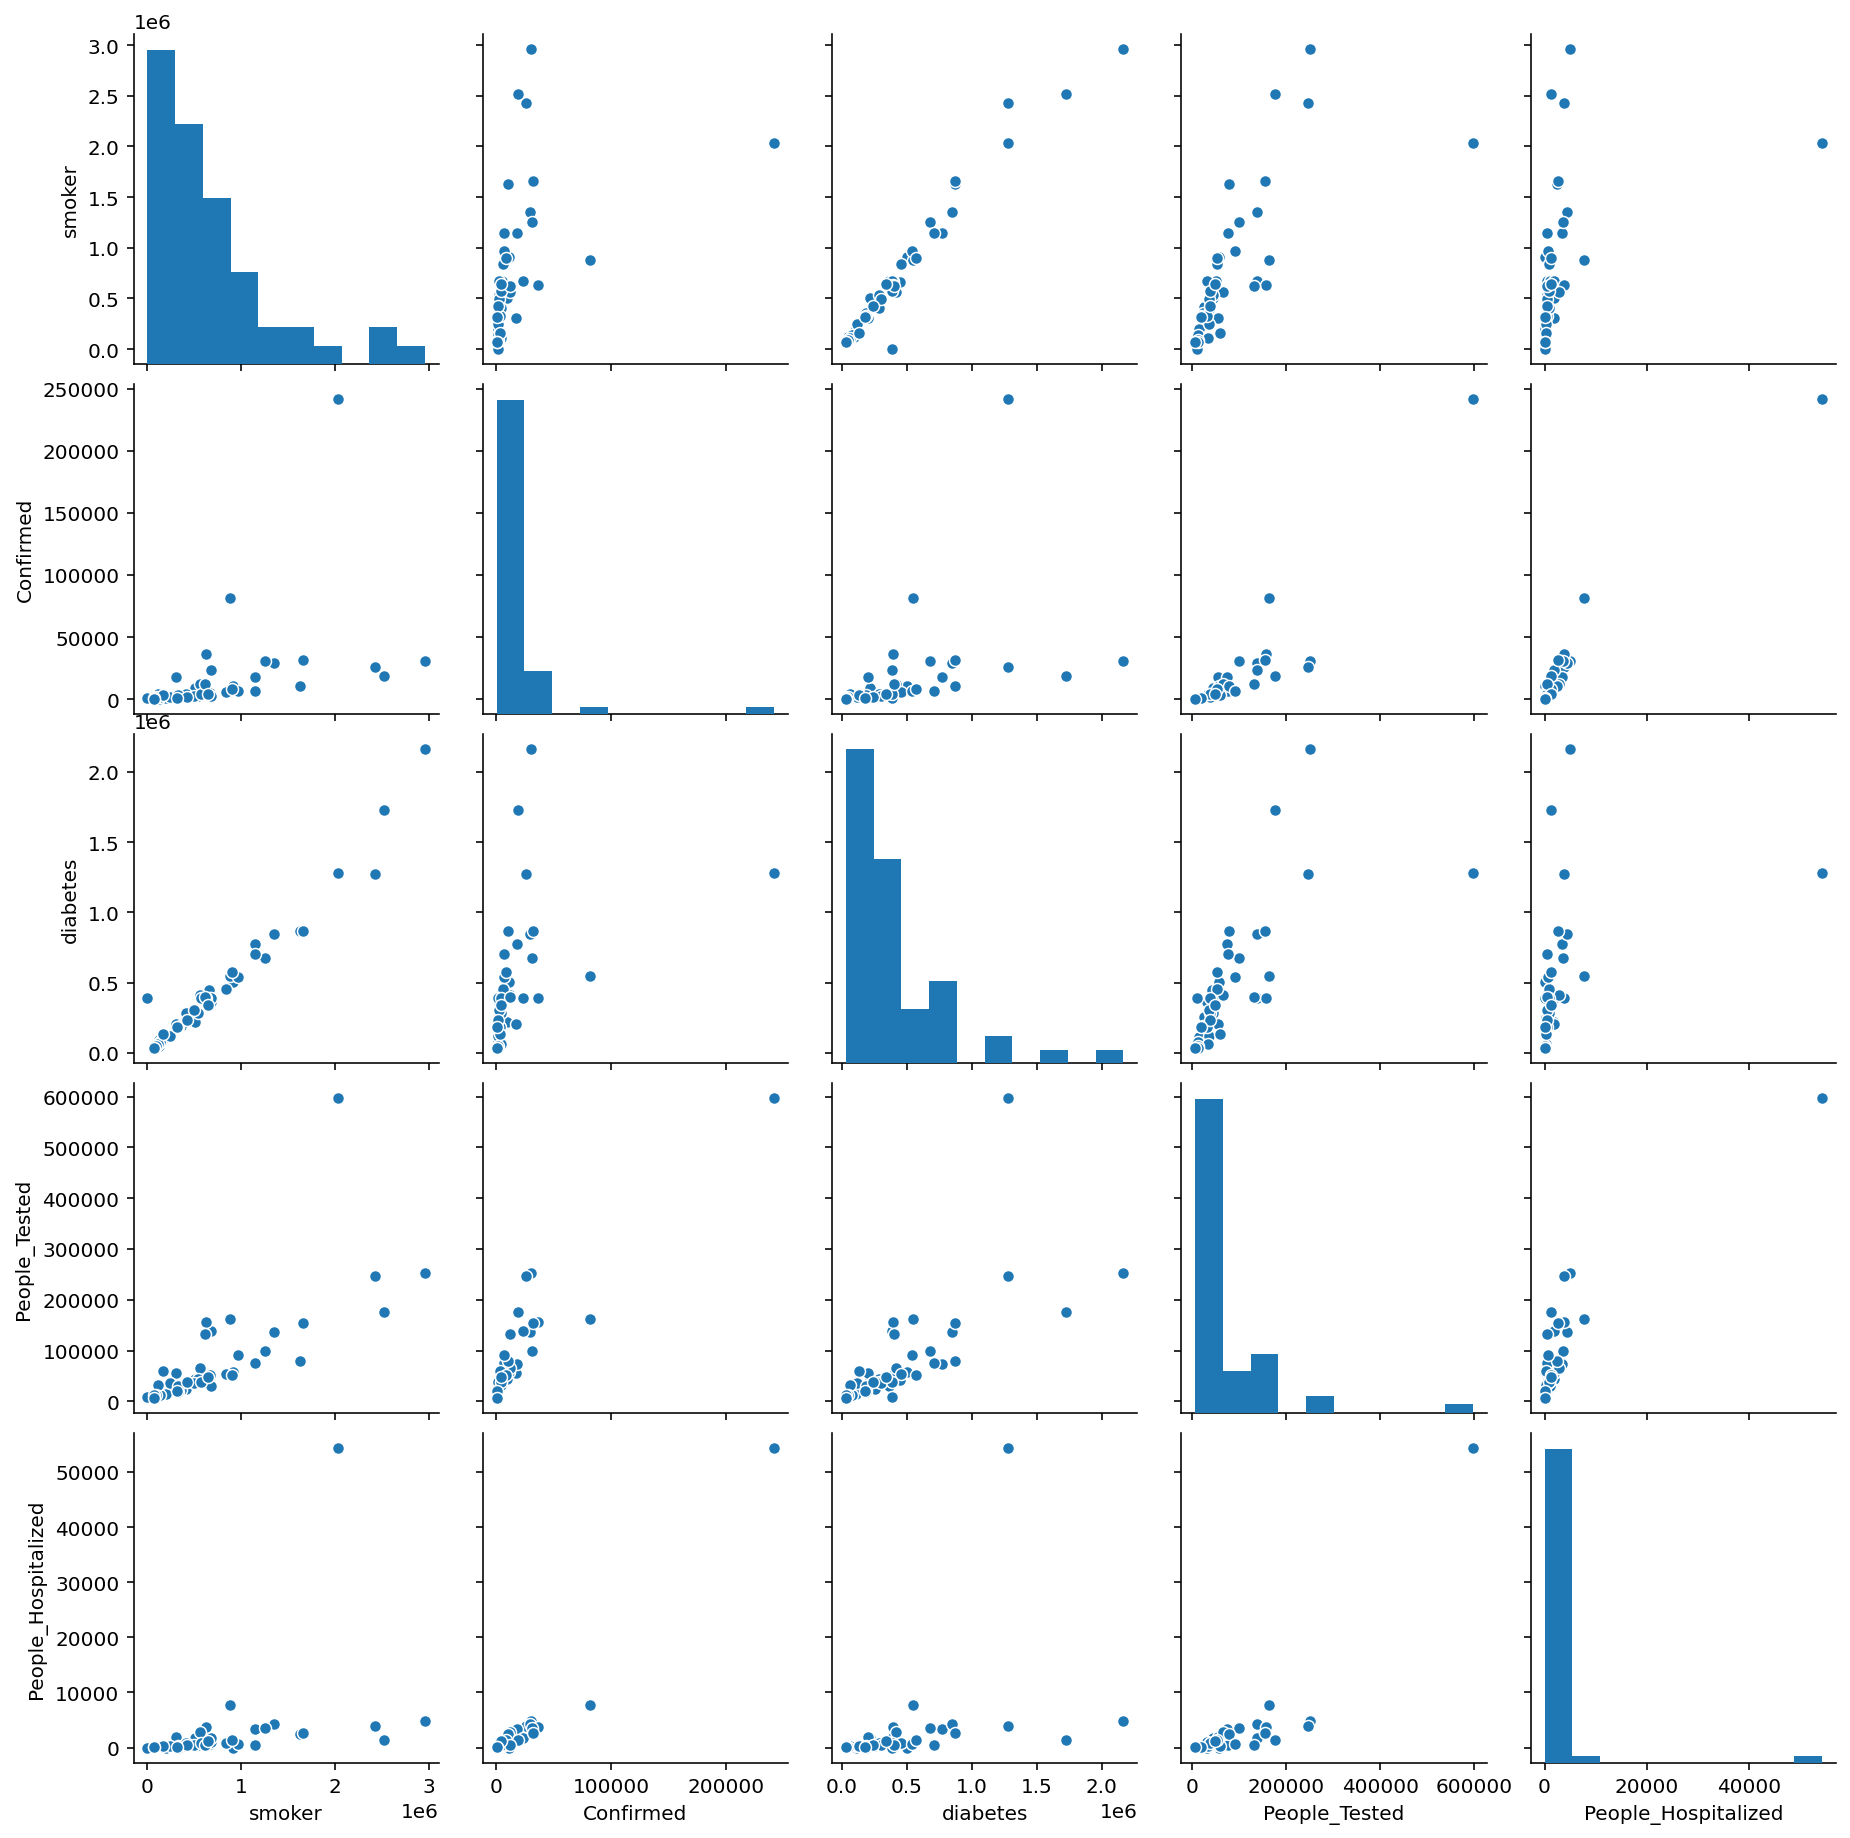

In [17]:
#plot a pairplot to visualize colinearity of some manual choosen features
small_samll = state_level_stat.loc[:,['smoker','Confirmed','diabetes','People_Tested','People_Hospitalized']]
sns.pairplot(small_samll)

In [18]:
# helper functions

def standardize(train, X):
    return (X - np.mean(train, axis = 0)) / np.std(train, axis = 0)
def rmse(predicted, actual):
    return np.sqrt(np.mean((actual - predicted)**2))

# set up training and validation data
def preprocessing(data, dropcolumns) :
    training_data = data.drop(columns = dropcolumns)
    train, val = train_test_split(training_data, test_size=0.2, random_state=42)
    x_train = train.drop(columns = ['Confirmed','StateName'])
    y_train = train.loc[:,'Confirmed']
    x_val = val.drop(columns = ['Confirmed','StateName'])
    y_val = val.loc[:,'Confirmed']

    return training_data,train, val,x_train, y_train,x_val,y_val

In [19]:
state_level_stat

,StateName,PopulationEstimate2018,#EligibleforMedicare2018,"MedicareEnrollment,AgedTot2017",smoker,diabetes,#FTEHospitalTotal2017,"TotalM.D.'s,TotNon-FedandFed2017",#HospParticipatinginNetwork2017,#Hospitals,...,SVIPercentile,STATEFP,age<20,20<=age<65,age>=65,FIPS,Confirmed,People_Tested,People_Hospitalized,Testing_Rate
0,AK,737438.0,101293.0,79279.0,86087,39899,15003.0,2100.0,1.0,22.0,...,0.509219,2,207840.0,447453.0,54938.0,2,314,9655.0,39.0,1615.226458
1,AL,4887871.0,1080141.0,781836.0,661404,449795,88369.0,12954.0,11.0,86.0,...,0.702722,1,1276312.0,2845632.0,657792.0,1,4712,42538.0,620.0,907.206961
2,AR,3013825.0,670352.0,480990.0,415952,257792,58025.0,7753.0,32.0,74.0,...,0.718023,5,795930.0,1700007.0,419981.0,5,1744,24141.0,291.0,932.435235
3,AZ,7171646.0,1346727.0,1072318.0,670754,392293,98442.0,20222.0,27.0,76.0,...,0.846067,4,1819641.0,3690545.0,881831.0,4,4724,51045.0,566.0,701.291175
4,CA,39557045.0,6466995.0,5268063.0,2957350,2165886,551825.0,137635.0,107.0,329.0,...,0.634397,6,10452042.0,22555400.0,4246514.0,6,30491,251614.0,4892.0,641.731334
5,CO,5695564.0,965047.0,745047.0,504634,220946,82584.0,19021.0,21.0,80.0,...,0.395428,8,1364692.0,3114879.0,549625.0,8,9047,43307.0,1755.0,764.221442
6,CT,3572665.0,702030.0,572565.0,308191,205042,61485.0,16693.0,19.0,30.0,...,0.316962,9,915776.0,2151762.0,506559.0,9,17550,55462.0,1946.0,1555.611091
7,DC,702455.0,98483.0,76006.0,76316,42064,29315.0,6524.0,0.0,6.0,...,0.596500,11,123720.0,409194.0,68809.0,11,2666,13268.0,313.0,1879.988494
8,DE,967171.0,210651.0,166602.0,104355,65140,21793.0,2950.0,0.0,6.0,...,0.501600,10,233803.0,534854.0,129277.0,10,2538,14017.0,224.0,1439.465825
9,FL,21299325.0,4738978.0,3747058.0,2425546,1275497,314333.0,70226.0,54.0,178.0,...,0.650343,12,4512990.0,11028718.0,3259602.0,12,25492,246527.0,3842.0,1161.077449


In [20]:
# Step #2 : Training models
# Select Models to find features that affect infection

In [21]:
# train test split
dropcolumns = ["POP_LATITUDE", "POP_LONGITUDE", 'STATEFP', 'FIPS','SVIPercentile','HPSAShortage','HPSAUnderservedPop','HPSAServedPop']
training_data,train, val,x_train, y_train ,x_val, y_val = preprocessing(state_level_stat,dropcolumns)


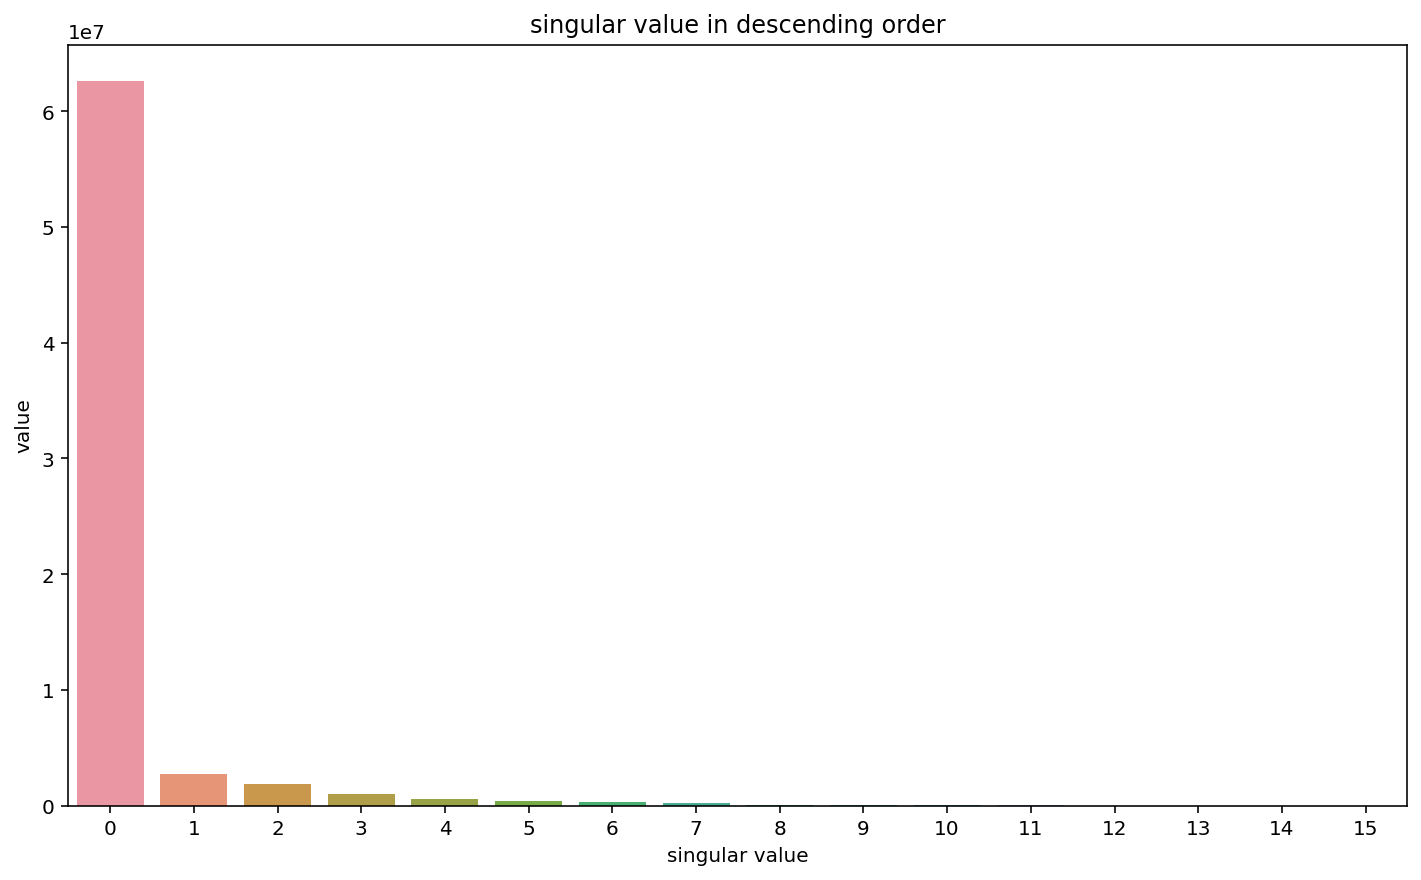

In [22]:
# doing SVD to find singular values of data

#training data contains all x value and all y value as well as statename to identify states
#use standardized data to train PCA model
data_for_SVD = training_data.drop(columns = ['Confirmed','StateName'])
data_for_SVD = data_for_SVD - np.mean(data_for_SVD, axis=0)

u, s, vt = np.linalg.svd(data_for_SVD, full_matrices=False)
sns.barplot(x = list(range(len(s))),y= s)
plt.xlabel('singular value')
plt.ylabel('value')
plt.title('singular value in descending order');

In [23]:
# scatterplot of the first two principal components of the data
import plotly.express as px

first_2_pcs = pd.DataFrame(data = (u @ np.diag(s))[:, 0:2], columns=["pc1", "pc2"])

fig = px.scatter(first_2_pcs, x='pc1', y='pc2', text=list(training_data.StateName), size_max=60)

fig.update_traces(textposition='top center')

fig.update_layout(
    height=800,
    title_text= 'PCA of COVID-19 by States'
)

fig.show()

training_rmse: 7074.772316955587

val_rmse: 3343.5014530310254


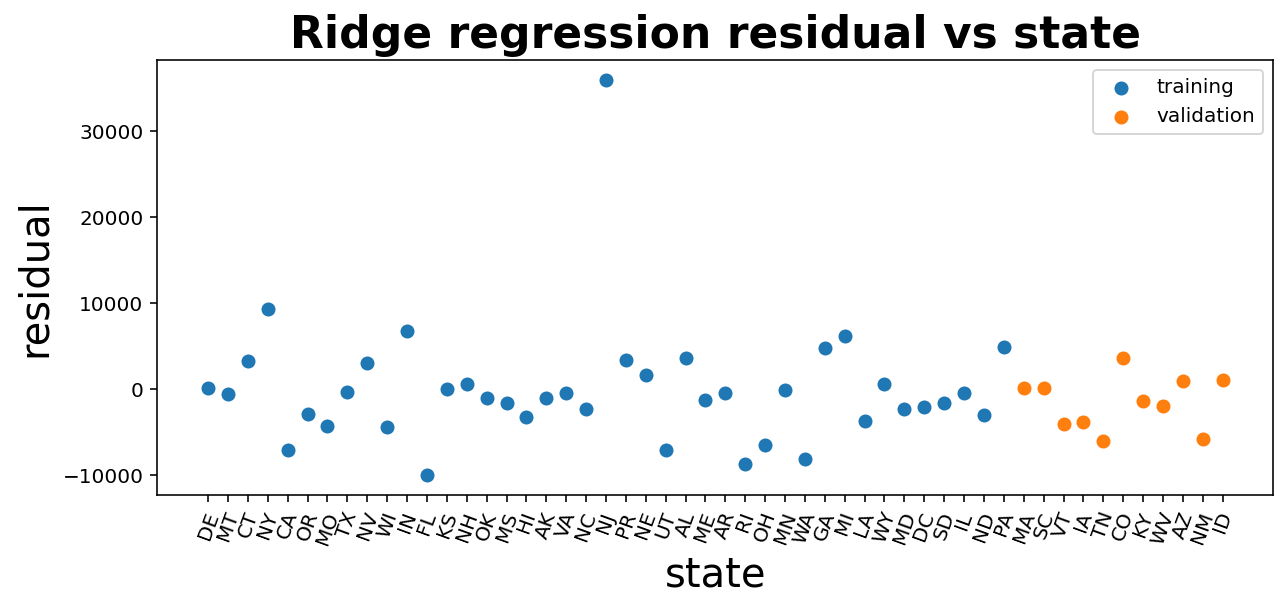

In [24]:
# Ridge regression with cross-validation using default alpha:

Ridgemodel = RidgeCV(normalize = True)

Ridgemodel.fit(x_train, y_train)
training_rmse = rmse(Ridgemodel.predict(x_train), y_train)
val_rmse = rmse(Ridgemodel.predict(x_val), y_val)
print('training_rmse:', str(training_rmse))
print('\nval_rmse:', val_rmse)
plt.figure(figsize=(10, 4))
plt.scatter(train['StateName'], y_train - Ridgemodel.predict(x_train), label="training")
plt.scatter(val['StateName'], y_val - Ridgemodel.predict(x_val), label="validation")
plt.title("Ridge regression residual vs state", fontsize = 22, fontweight='bold')
plt.xticks(rotation=70)
plt.legend()
plt.xlabel("state", fontsize=20)
plt.ylabel("residual", fontsize=20);

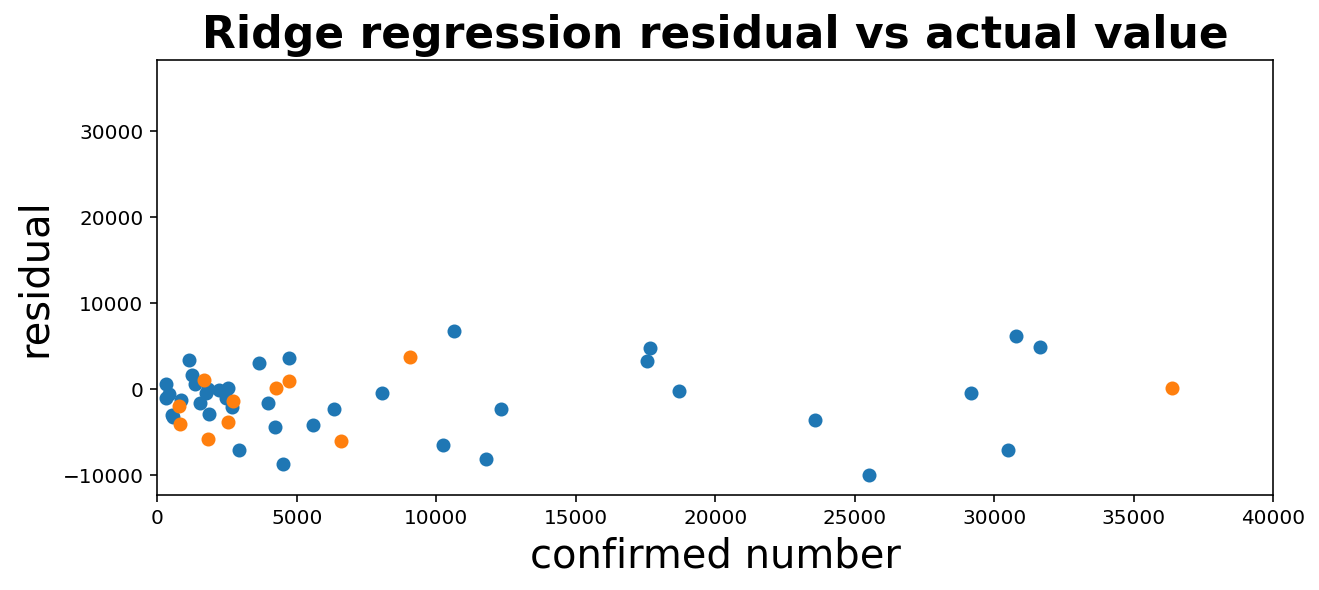

In [25]:
# Residual vs real value
plt.figure(figsize=(10, 4))
plt.scatter(y_train, y_train - Ridgemodel.predict(x_train))
plt.xlim((0,40000))
plt.scatter(y_val, y_val - Ridgemodel.predict(x_val))
plt.title("Ridge regression residual vs actual value", fontsize = 22, fontweight='bold')
plt.xlabel("confirmed number", fontsize=20)
plt.ylabel("residual", fontsize=20);

In [26]:
# select features by backward selection
x_train_backward = x_train.copy()
x_val_backward = x_val.copy()
rmse_backward_selcetion = []


droped_features = []
for i in range(x_train.shape[1] - 1):
    curr_rmse = []
    features = []
    for feature in x_train_backward.columns:
        x_train_droped = x_train_backward.drop(columns=[feature])
        x_val_droped = x_val_backward.drop(columns=[feature])
        Ridgemodel = RidgeCV(normalize = True)
        Ridgemodel.fit(x_train_droped, y_train)
        mse = rmse(y_train, Ridgemodel.predict(x_train_droped))
        curr_rmse.append(mse)
        features.append(feature)
    index = np.argmin(curr_rmse)
    curr_rmse = curr_rmse[index]

    # stop if dropping current features increase MSE
    if len(rmse_backward_selcetion) > 1:
        if curr_rmse >= rmse_backward_selcetion[-1]:
            break

    rmse_backward_selcetion.append(curr_rmse)
    droped_features.append(features[index])
    x_train_backward = x_train_backward.drop(columns=[features[index]])
    x_val_backward = x_val_backward.drop(columns=[features[index]])

In [27]:
# Features dropped
print("droped_features: ")
print(droped_features)
print("kept features: ")
print(list(x_train_backward.columns))

droped_features: 
['Testing_Rate', "TotalM.D.'s,TotNon-FedandFed2017", '#FTEHospitalTotal2017', 'age>=65']
kept features: 
['PopulationEstimate2018', '#EligibleforMedicare2018', 'MedicareEnrollment,AgedTot2017', 'smoker', 'diabetes', '#HospParticipatinginNetwork2017', '#Hospitals', '#ICU_beds', 'age<20', '20<=age<65', 'People_Tested', 'People_Hospitalized']


In [28]:
# corresponding validation MSE
rmse_backward_selcetion

[6946.424369244837, 6923.625731337514, 6902.599504563834, 6902.327259667831]

training_rmse: 6902.327259667831

val_rmse: 3047.3603139521465


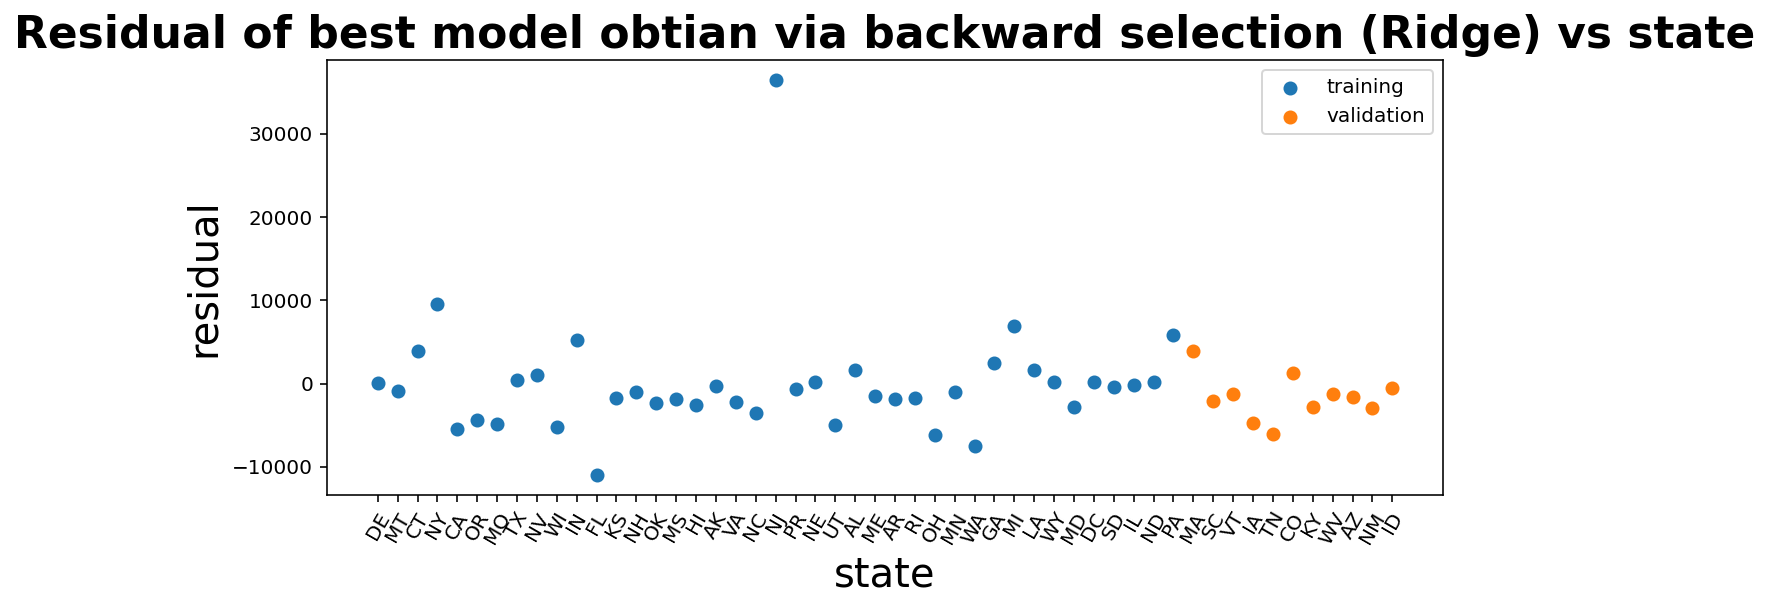

In [29]:
# best model obtain via feature selection (dropped 3 features)
Ridgemodel = RidgeCV(normalize = True)

Ridgemodel.fit(x_train_backward, y_train)
training_rmse = rmse(Ridgemodel.predict(x_train_backward), y_train)
val_rmse = rmse(Ridgemodel.predict(x_val_backward), y_val)
print('training_rmse:', training_rmse)
print('\nval_rmse:', val_rmse)
plt.figure(figsize=(10, 4))
plt.scatter(train['StateName'], y_train - Ridgemodel.predict(x_train_backward), label="training")
plt.scatter(val['StateName'], y_val - Ridgemodel.predict(x_val_backward), label="validation")
plt.title("Residual of best model obtian via backward selection (Ridge) vs state", fontsize = 22, fontweight='bold')
plt.xlabel("state", fontsize=20)
plt.xticks(rotation=60)
plt.legend()
plt.ylabel("residual", fontsize=20);

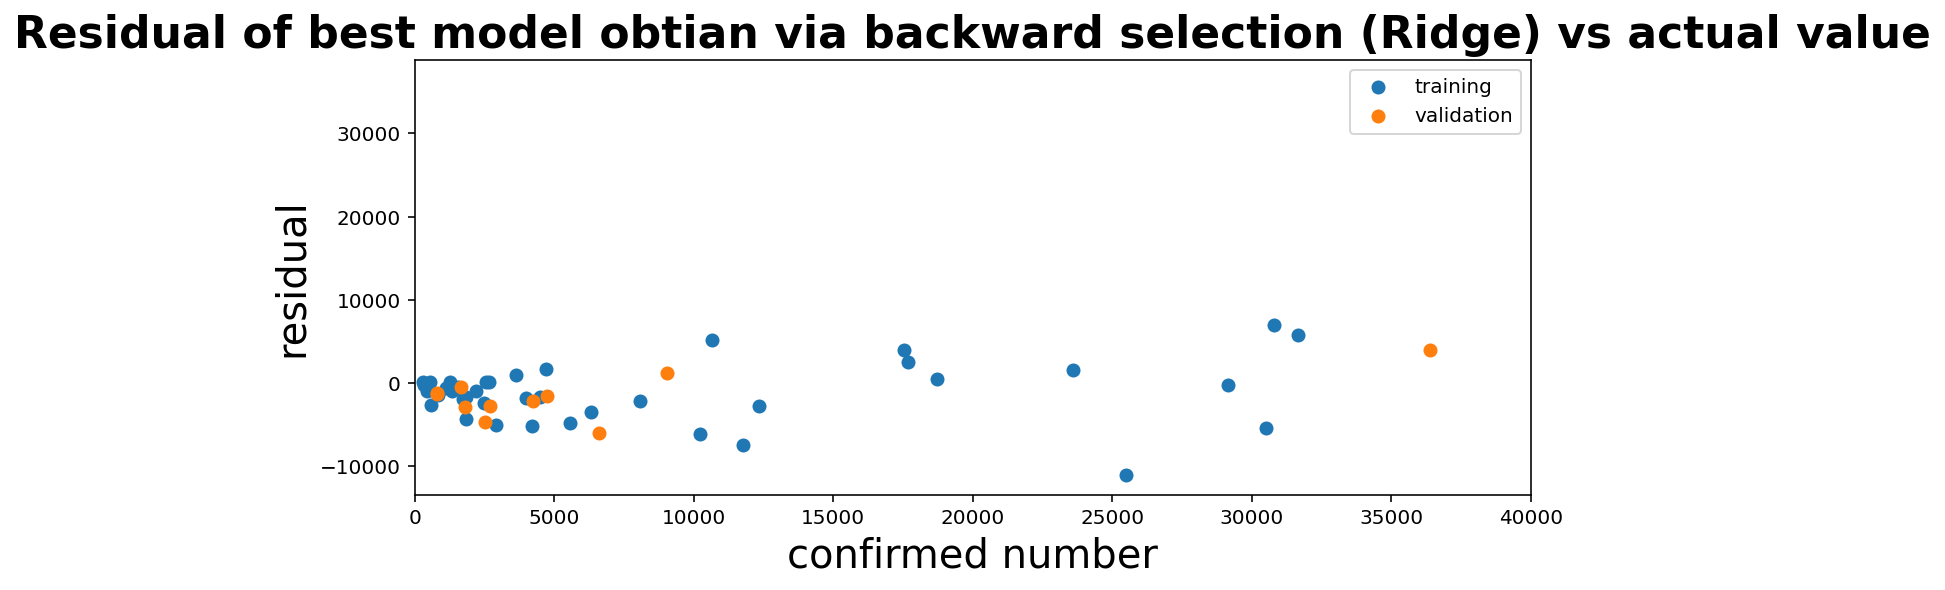

In [30]:
plt.figure(figsize=(10, 4))
plt.scatter(y_train, y_train - Ridgemodel.predict(x_train_backward), label="training")
plt.scatter(y_val, y_val - Ridgemodel.predict(x_val_backward), label="validation")
plt.title("Residual of best model obtian via backward selection (Ridge) vs actual value", fontsize = 22, fontweight='bold')
plt.xlabel("confirmed number", fontsize=20)

plt.xlim((0,40000))
plt.legend()
plt.ylabel("residual", fontsize=20);

In [31]:
Ridgemodel.coef_

array([-1.08713449e-04, -8.23805248e-04, -9.27395546e-04,  9.02898446e-04,
        1.55331059e-03,  1.30533379e+02, -6.15002237e+01, -9.42627112e-01,
        1.26708545e-04,  1.84646342e-04,  1.55651882e-01,  2.58804072e+00])

In [32]:
x_train_backward.columns

Index(['PopulationEstimate2018', '#EligibleforMedicare2018',
       'MedicareEnrollment,AgedTot2017', 'smoker', 'diabetes',
       '#HospParticipatinginNetwork2017', '#Hospitals', '#ICU_beds', 'age<20',
       '20<=age<65', 'People_Tested', 'People_Hospitalized'],
      dtype='object')

In [33]:
Ridgemodel.intercept_

301.0632742267626

In [34]:
Ridgemodel.alpha_

0.1